# **LAB-05 DE SIS421**

### Nombre: Gonzales Suyo Franz Reinaldo

### C.U. 111-500

### Link HitHub: https://github.com/Gonzales-Franz-Reinaldo/SIS421-IA2/tree/main/Laboratorios/LAB-05_GANs


##Contexto del Laboratorio

###LABORATORIO 05

A partir del dataset de plantas medicinales conformado con todos los estudiantes, realizar el respectivo preprocesamiento y adecuacion para lograr generar nuevas plantas utilizando un modelo DCGAN , el cual debera ser entrenado con el dataset que cada uno prepare de acuerdo a su criterio, en caso de que algun estudiante no hubiese cumplido con subir todas las imagenes solicitadas al drive o hubiera incluido imagenes con errores, o que no cumplan con las exigencias establecidas, se debe hacer conocer esto oportunamente o en su caso los errores que genere esta situacion sera responsabilidad de cada estudiante.

El trabajo debe considerar lo siguiente:

- El dataset debe contener las imagenes suficientes para lograr una generacion aceptable.
- El tamaño de las imagenes debe ser minimamente de 50x50 pixel.
- La participacion de todos los estudiantes es obligatoria y habilitante al primer parcial.
- El responsable de emitir el informe de trabajo es el universitario: Aparicio Llanquipacha Gabriel.
Como todo laboratorio, debe ser subido a ecampus y github, ya sea en cuadernillo o como archivo .py.

In [1]:
import torch
import torchvision
import os
from torch.utils.data import Dataset
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from collections import Counter

import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1: Lectura del Dataset

In [3]:
# Definir las transformaciones para las imágenes
from torchvision import datasets, transforms
import torch.utils.data

# Definir las transformaciones para el conjunto de datos
transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Redimensionar las imágenes a 50x50 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalizar entre [-1, 1] para las 3 bandas de color (RGB)
])


# Cargar el conjunto de datos de entrenamiento y prueba con las transformaciones
train_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train', transform=transform)
test_data = datasets.ImageFolder(root='/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_test', transform=transform)

# Mostrar la cantidad de imágenes de entrenamiento y prueba
print(f"Número de imágenes de entrenamiento: {len(train_data)}")
print(f"Número de imágenes de prueba: {len(test_data)}")

Número de imágenes de entrenamiento: 60000
Número de imágenes de prueba: 15000


In [4]:

# Función para limitar el número de archivos de cada subcarpeta
def limit_dataset_size(root_dir, max_per_class=6000):
    # Diccionario para almacenar rutas de las imágenes seleccionadas por clase
    limited_dataset = []

    # Iteramos por las subcarpetas en root_dir (cada subcarpeta es una clase)
    for class_name in os.listdir(root_dir):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            # Obtenemos todas las imágenes en la subcarpeta
            all_images = os.listdir(class_dir)
            # Filtramos para obtener solo imágenes, excluyendo otros tipos de archivos
            all_images = [os.path.join(class_name, img) for img in all_images if img.endswith(('.png', '.jpg', '.jpeg'))]
            # Seleccionamos aleatoriamente 6000 imágenes
            selected_images = random.sample(all_images, min(len(all_images), max_per_class))
            limited_dataset.extend(selected_images)

    return limited_dataset


In [5]:
# Definir la ruta del dataset
root_dir = '/content/drive/MyDrive/SIS420-IA2/Plantas Medicinales/plantas_train'

# Obtener una lista de las rutas de imágenes limitadas a 6000 por clase
limited_image_paths = limit_dataset_size(root_dir, max_per_class=6000)

# Clase personalizada para cargar solo las imágenes seleccionadas
class CustomImageFolder(datasets.ImageFolder):
    def __init__(self, root, selected_files, transform=None):
        super(CustomImageFolder, self).__init__(root, transform=transform)
        # Filtrar el dataset para cargar solo las imágenes seleccionadas
        self.samples = [(os.path.join(root, img), self.class_to_idx[img.split('/')[0]]) for img in selected_files]
        self.targets = [s[1] for s in self.samples]  # Extraer las etiquetas


# Crear el dataset personalizado usando solo las imágenes seleccionadas
train_data = CustomImageFolder(root=root_dir, selected_files=limited_image_paths, transform=transform)

# Verificar el número de imágenes en el nuevo conjunto de entrenamiento
print(f"Número total de imágenes en el nuevo conjunto de entrenamiento: {len(train_data)}")

# Verificar el número de imágenes por clase
from collections import Counter
print("Distribución de imágenes por clase:", Counter(train_data.targets))

Número total de imágenes en el nuevo conjunto de entrenamiento: 30000
Distribución de imágenes por clase: Counter({0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000})


In [ ]:
# 1. Ver las etiquetas del dataset (clases):
# Ver las clases del dataset (etiquetas)
print(f"Clases en el conjunto de entrenamiento: {train_data.classes}")
print(f"Cantidad de clases: {len(train_data.classes)}")

Clases en el conjunto de entrenamiento: ['Acelga', 'Cebolla', 'Espinaca', 'Lechuga', 'Toronjil']
Cantidad de clases: 5


In [ ]:
import torch
from collections import Counter

# Verificar el número total de imágenes en el conjunto de entrenamiento
num_total_images = len(train_data)
print(f"Número total de imágenes en el conjunto de entrenamiento: {num_total_images}")

# Verificar el número de clases (etiquetas)
num_classes = len(train_data.classes)
print(f"Número de clases: {num_classes}")

# Obtener las etiquetas de todas las imágenes (train_data.targets tiene las etiquetas de cada imagen)
class_distribution = Counter(train_data.targets)

# Mostrar cuántas imágenes hay por clase
for class_idx, count in class_distribution.items():
    print(f"Clase '{train_data.classes[class_idx]}' tiene {count} imágenes")


Número total de imágenes en el conjunto de entrenamiento: 30000
Número de clases: 5
Clase 'Acelga' tiene 6000 imágenes
Clase 'Cebolla' tiene 6000 imágenes
Clase 'Espinaca' tiene 6000 imágenes
Clase 'Lechuga' tiene 6000 imágenes
Clase 'Toronjil' tiene 6000 imágenes


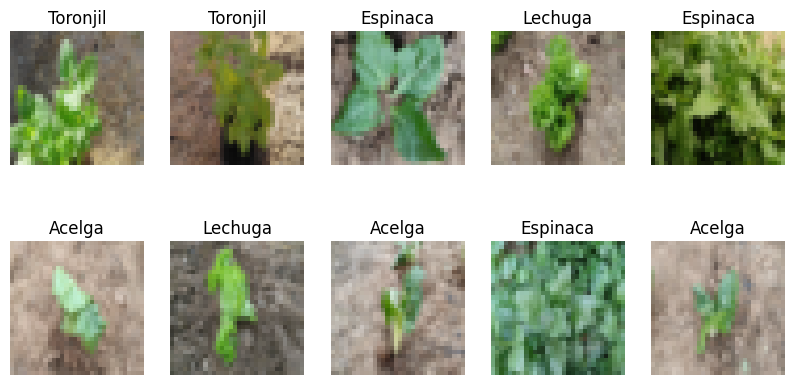

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

# Obtener las clases del dataset
classes = train_data.classes

# Convertir las imágenes y etiquetas a arrays numpy para facilitar el procesamiento
def imshow(img):
    img = img / 2 + 0.5     # Desnormalizar
    npimg = img.numpy()
    return np.transpose(npimg, (1, 2, 0))

# Mostrar 10 imágenes aleatorias
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    index = random.randint(0, len(train_data) - 1)
    img, label = train_data[index]
    plt.imshow(imshow(img))
    plt.title(classes[label])
    plt.axis('off')

plt.show()

El dataset está formado por 60000 imágenes de baja resolución (50 x 50 píxeles, con tres canales de colores) y contiene 5 tipos plantas medicinales (Acelga, Cebolla, Espinaca, Lechuga y Toronjil)

In [ ]:
# Definir una clase personalizada para el dataset que normalice a [-1, 1]
class PlantDatasetPrep(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.imgs = torch.stack([img[0] for img in dataset])  # Cargar las imágenes como tensores
        self.imgs = self.imgs * 2. - 1.  # Normalizar a [-1, 1]
        self.labels = torch.tensor([img[1] for img in dataset], dtype=torch.long)  # Etiquetas de las imágenes

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx], self.labels[idx]


In [ ]:
# Crear el dataset normalizado
train_dataset = PlantDatasetPrep(train_data)

In [6]:
# Dividimos las imagens por baches
dataloader = torch.utils.data.DataLoader(train_data, batch_size=32, shuffle=True)

#**MODELO DCGANs**

2. Definir el Generador (Generator)
Ahora, ajustamos el generador para manejar imágenes a color (3 canales) de tamaño 50x50

In [7]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100  # Tamaño del vector aleatorio de entrada (latent vector)

        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 4*4*256),  # Transformamos el vector de entrada en un mapa de características de 4x4x256
            nn.BatchNorm1d(4*4*256),  # Normalización batch para estabilizar el entrenamiento
            nn.ReLU(True)
        )

        self.main = nn.Sequential(
            # Primera capa de deconvolución: 4x4x256 -> 8x8x128
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),

            # Segunda capa de deconvolución: 8x8x128 -> 16x16x64
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            # Tercera capa de deconvolución: 16x16x64 -> 32x32x3 (RGB)
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Normalizamos la salida a un rango [-1, 1]
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 256, 4, 4)  # Ajustamos la forma para la entrada de 4x4 con 256 canales
        x = self.main(x)
        return x


In [8]:
# Verifica el tamaño de salida
generator = Generator()
output = generator(torch.randn(64, 100))
print(output.shape)


torch.Size([64, 3, 32, 32])


###3. Definir el Discriminador (Discriminator)
Modificamos el discriminador para aceptar imágenes a color de tamaño 50x50:

In [9]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # Primera capa convolucional: 32x32x3 -> 16x16x64
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # Segunda capa convolucional: 16x16x64 -> 8x8x128
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            # Tercera capa convolucional: 8x8x128 -> 4x4x256
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            # Cuarta capa convolucional: 4x4x256 -> 2x2x512
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )

        self.out = nn.Sequential(
            # Capa lineal para la clasificación
            nn.Linear(512*2*2, 1),  # Aplana el tensor de salida de la capa convolucional
            nn.Sigmoid()  # Salida entre 0 y 1
        )

    def forward(self, x):
        x = self.main(x)  # Pasar la entrada a través de las capas convolucionales
        x = x.view(x.size(0), -1)  # Aplana el tensor
        x = self.out(x)  # Pasar a través de la capa lineal final
        return x


In [10]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 3, 40, 40))
print(output.shape)

torch.Size([64, 1])


###4. Definimos el Proceso de Entrenamiento
Configuramos el bucle de entrenamiento, la función de pérdida y los optimizadores:

In [ ]:
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=100, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/', save_interval=5):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    g_loss, d_loss = [], []
    mb = master_bar(range(1, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Crear el directorio de checkpoints si no existe
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Aseguramos que las imágenes reales vayan al dispositivo

            # Entrenamos el discriminador
            g.eval()
            d.train()

            # Generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Vector de ruido
            generated_images = g(noise)  # Generamos imágenes falsas

            # Concatenamos imágenes reales y generadas para el discriminador
            d_input = torch.cat([generated_images, X], dim=0)
            # Creamos etiquetas: 0 para imágenes falsas y 1 para reales
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimizamos el discriminador
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Entrenamos el generador
            g.train()
            d.eval()

            # Generamos un nuevo batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pasamos las imágenes falsas por el discriminador
            d_output = d(generated_images)
            # Objetivo del generador: engañar al discriminador, por eso usamos etiquetas de "reales" (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimizamos el generador
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Logs de progreso
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))


        # Guardar un checkpoint cada 'save_interval' épocas
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist


In [ ]:
# Ejecuta el entrenamiento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss())

## CONTINUANDO CON EL ENTRENAMIENTO

In [11]:
from fastprogress import master_bar, progress_bar

def load_checkpoint(checkpoint_path, g, d, g_optimizer, d_optimizer):
    checkpoint = torch.load(checkpoint_path)
    g.load_state_dict(checkpoint['generator_state_dict'])
    d.load_state_dict(checkpoint['discriminator_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    start_epoch = checkpoint['epoch'] + 1  # Reanudar desde el siguiente epoch
    g_loss = checkpoint['g_loss']
    d_loss = checkpoint['d_loss']
    return start_epoch, g_loss, d_loss


In [ ]:
def fit(g, d, dataloader, epochs=100, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # Si se retoma desde un checkpoint, cargar el modelo, optimizadores y pérdidas
    if resume_from_checkpoint:
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Crear el directorio de checkpoints si no existe
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Aseguramos que las imágenes reales vayan al dispositivo

            # Entrenamos el discriminador
            g.eval()
            d.train()

            # Generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Vector de ruido
            generated_images = g(noise)  # Generamos imágenes falsas

            # Concatenamos imágenes reales y generadas para el discriminador
            d_input = torch.cat([generated_images, X], dim=0)
            # Creamos etiquetas: 0 para imágenes falsas y 1 para reales
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimizamos el discriminador
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Entrenamos el generador
            g.train()
            d.eval()

            # Generamos un nuevo batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pasamos las imágenes falsas por el discriminador
            d_output = d(generated_images)
            # Objetivo del generador: engañar al discriminador, por eso usamos etiquetas de "reales" (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimizamos el generador
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Logs de progreso
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Guardar un checkpoint cada 'save_interval' épocas
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [ ]:
# Ejecutar el entrenamiento desde el último checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/GANs_modelo_20.pth'  # Cambia esto por tu último checkpoint guardado
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), resume_from_checkpoint=checkpoint_path)

<ipython-input-11-e57625311951>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


In [12]:
def fit(g, d, dataloader, epochs=100, crit=None, checkpoint_dir='/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/', save_interval=5, resume_from_checkpoint=None):
    g.to(device)
    d.to(device)

    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

    crit = nn.BCEWithLogitsLoss() if crit is None else crit

    # Si se retoma desde un checkpoint, cargar el modelo, optimizadores y pérdidas
    if resume_from_checkpoint:
        start_epoch, g_loss, d_loss = load_checkpoint(resume_from_checkpoint, g, d, g_optimizer, d_optimizer)
    else:
        start_epoch = 1
        g_loss, d_loss = [], []

    mb = master_bar(range(start_epoch, epochs+1))
    hist = {'g_loss': [], 'd_loss': []}

    # Crear el directorio de checkpoints si no existe
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    for epoch in mb:
        for X, _ in progress_bar(dataloader, parent=mb):
            X = X.to(device)  # Aseguramos que las imágenes reales vayan al dispositivo

            # Entrenamos el discriminador
            g.eval()
            d.train()

            # Generamos un batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)  # Vector de ruido
            generated_images = g(noise)  # Generamos imágenes falsas

            # Concatenamos imágenes reales y generadas para el discriminador
            d_input = torch.cat([generated_images, X], dim=0)
            # Creamos etiquetas: 0 para imágenes falsas y 1 para reales
            d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)

            # Optimizamos el discriminador
            d_optimizer.zero_grad()
            d_output = d(d_input)
            d_l = crit(d_output, d_gt)
            d_l.backward()
            d_optimizer.step()
            d_loss.append(d_l.item())

            # Entrenamos el generador
            g.train()
            d.eval()

            # Generamos un nuevo batch de imágenes falsas
            noise = torch.randn((X.size(0), g.input_size)).to(device)
            generated_images = g(noise)

            # Pasamos las imágenes falsas por el discriminador
            d_output = d(generated_images)
            # Objetivo del generador: engañar al discriminador, por eso usamos etiquetas de "reales" (1)
            g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)

            # Optimizamos el generador
            g_optimizer.zero_grad()
            g_l = crit(d_output, g_gt)
            g_l.backward()
            g_optimizer.step()
            g_loss.append(g_l.item())

            # Logs de progreso
            mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'
        mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')
        hist['g_loss'].append(np.mean(g_loss))
        hist['d_loss'].append(np.mean(d_loss))

        # Guardar un checkpoint cada 'save_interval' épocas
        if epoch % save_interval == 0:
            torch.save({
                'epoch': epoch,
                'generator_state_dict': g.state_dict(),
                'discriminator_state_dict': d.state_dict(),
                'g_optimizer_state_dict': g_optimizer.state_dict(),
                'd_optimizer_state_dict': d_optimizer.state_dict(),
                'g_loss': g_loss,
                'd_loss': d_loss
            }, os.path.join(checkpoint_dir, f'GANs_modelo_{epoch}.pth'))

    return hist

In [ ]:
# Ejecutar el entrenamiento desde el último checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_path = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/GANs_modelo_25.pth'  # Cambia esto por tu último checkpoint guardado
hist = fit(generator, discriminator, dataloader, crit=torch.nn.BCELoss(), resume_from_checkpoint=checkpoint_path)

<ipython-input-11-e57625311951>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


##EVALUACIÓN DE LOS MODELOS

###Cargamos los modelos guardados para verificar el mejor medelo.

In [ ]:

import torch

# Cargar un model dado
def load_model(checkpoint_path, g, d, g_optimizer, d_optimizer):
    mo1del = torch.load(checkpoint_path)
    g.load_state_dict(mo1del['generator_state_dict'])
    d.load_state_dict(mo1del['discriminator_state_dict'])
    g_optimizer.load_state_dict(mo1del['g_optimizer_state_dict'])
    d_optimizer.load_state_dict(mo1del['d_optimizer_state_dict'])
    epoch = mo1del['epoch']
    g_loss = mo1del['g_loss']
    d_loss = mo1del['d_loss']
    print(f"Checkpoint loaded from epoch {epoch}")
    return epoch, g_loss, d_loss

In [ ]:
import matplotlib.pyplot as plt

def generate_and_plot_images(g, num_images=5):
    g.eval()  # Modo evaluación
    noise = torch.randn(num_images, g.input_size).to(device)
    with torch.no_grad():
        generated_images = g(noise).cpu()

    # Mostrar las imágenes generadas
    for i in range(num_images):
        img = generated_images[i].permute(1, 2, 0)  # Cambiar dimensiones a (H, W, C)
        img = (img + 1) / 2  # Desnormalizar si usas [-1, 1]
        plt.imshow(img)
        plt.show()


In [ ]:
import torch
import torch.optim as optim

# Definir el generador y discriminador
generator = Generator()
discriminator = Discriminator()

# Definir los optimizadores
g_optimizer = optim.Adam(generator.parameters(), lr=3e-4, weight_decay=1e-4)
d_optimizer = optim.Adam(discriminator.parameters(), lr=3e-4, weight_decay=1e-4)

Cargamos los modelos para ver los mejores valores resultados

<ipython-input-17-af439731a3a6>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mo1del = torch.load(checkpoint_path)


Checkpoint loaded from epoch 15
Evaluando el checkpoint del epoch 15: g_loss = 6.005204200744629, d_loss = 0.0042983777821063995


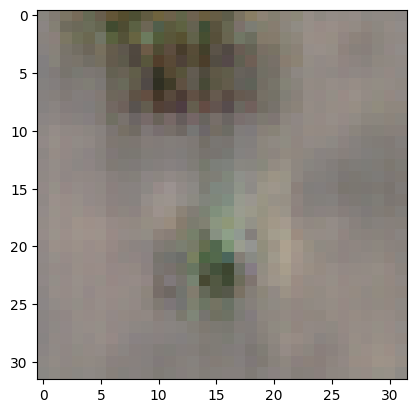

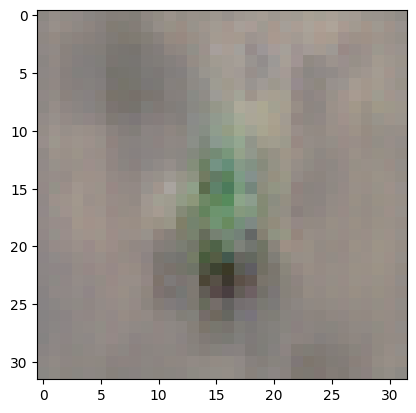

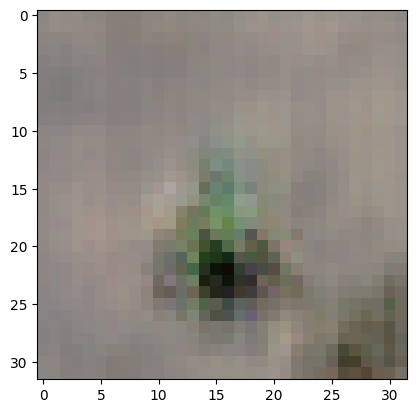

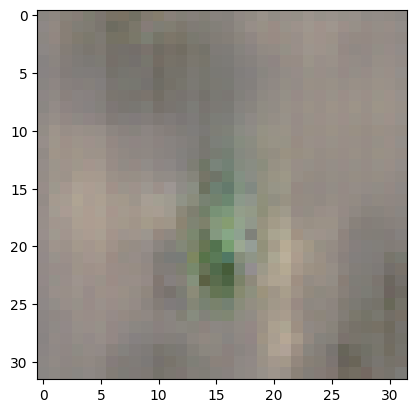

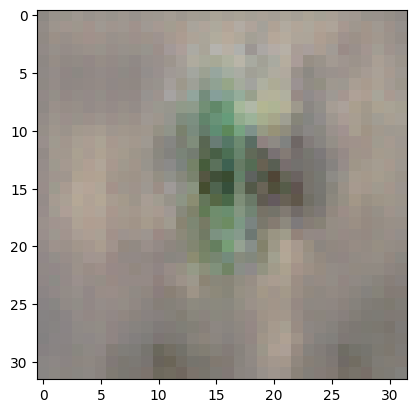

Checkpoint loaded from epoch 20
Evaluando el checkpoint del epoch 20: g_loss = 2.156456232070923, d_loss = 0.0014519710093736649


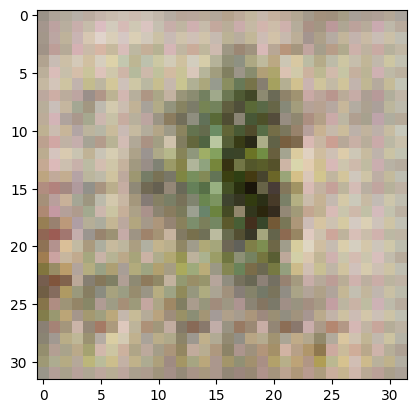

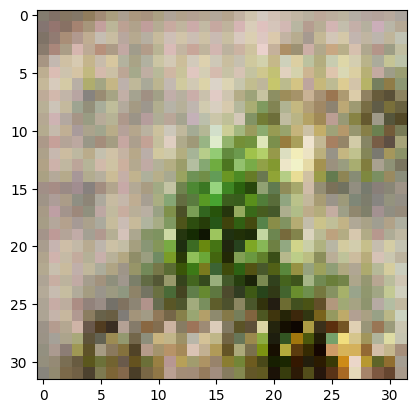

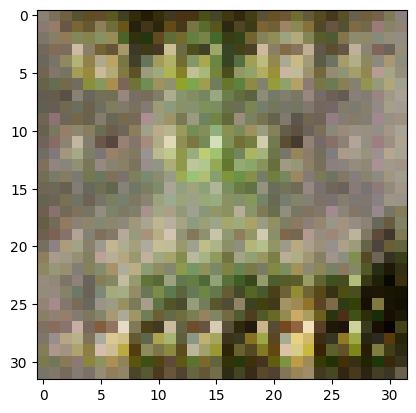

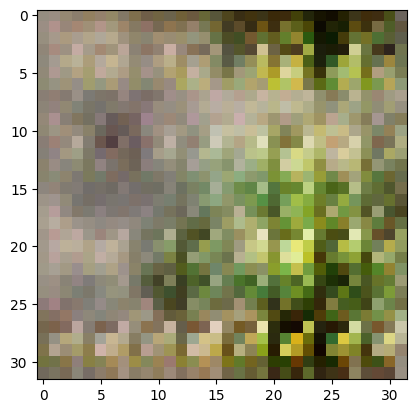

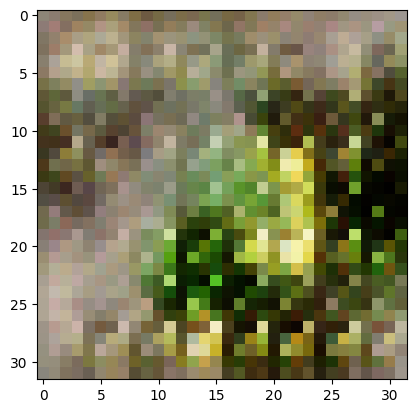

Checkpoint loaded from epoch 25
Evaluando el checkpoint del epoch 25: g_loss = 12.365166664123535, d_loss = 0.031084416434168816


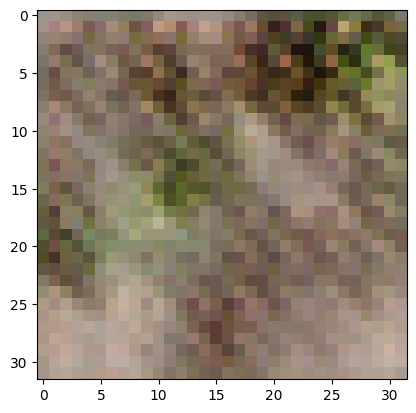

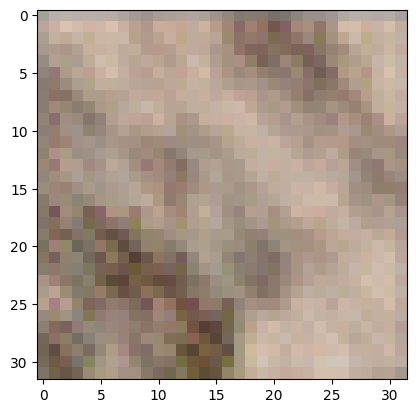

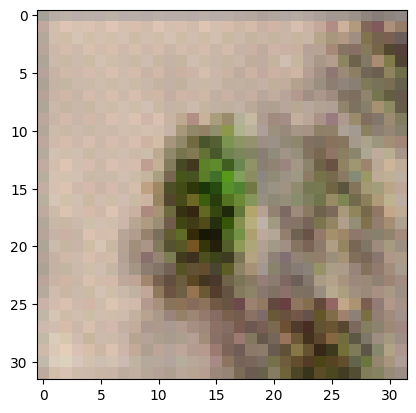

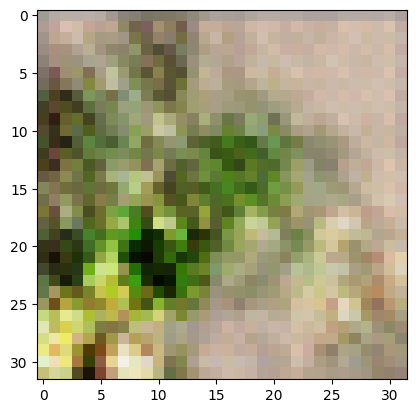

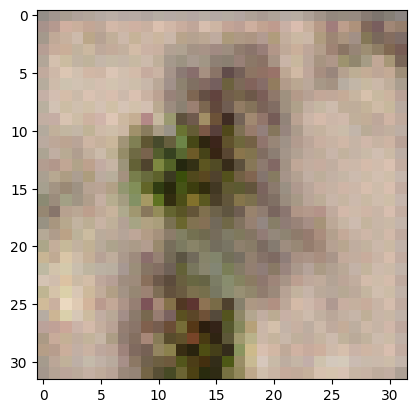

In [ ]:
models = [
    '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/GANs_modelo_15.pth',
    '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/GANs_modelo_20.pth',
    '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/GANs_modelo_25.pth'
]

for model in models:
    epoch, g_loss, d_loss = load_model(model, generator, discriminator, g_optimizer, d_optimizer)
    print(f"Evaluando el checkpoint del epoch {epoch}: g_loss = {g_loss[-1]}, d_loss = {d_loss[-1]}")
    generate_and_plot_images(generator, num_images=5)


In [ ]:
g_loss_total = []
d_loss_total = []

for model in models:
    epoch, g_loss, d_loss = load_model(model, generator, discriminator, g_optimizer, d_optimizer)
    g_loss_total.extend(g_loss)  # Agregar las pérdidas del generador
    d_loss_total.extend(d_loss)  # Agregar las pérdidas del discriminador

<ipython-input-17-af439731a3a6>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mo1del = torch.load(checkpoint_path)


Checkpoint loaded from epoch 15
Checkpoint loaded from epoch 20
Checkpoint loaded from epoch 25


Graficamos los Loss tanto para Generador y Discriminador.

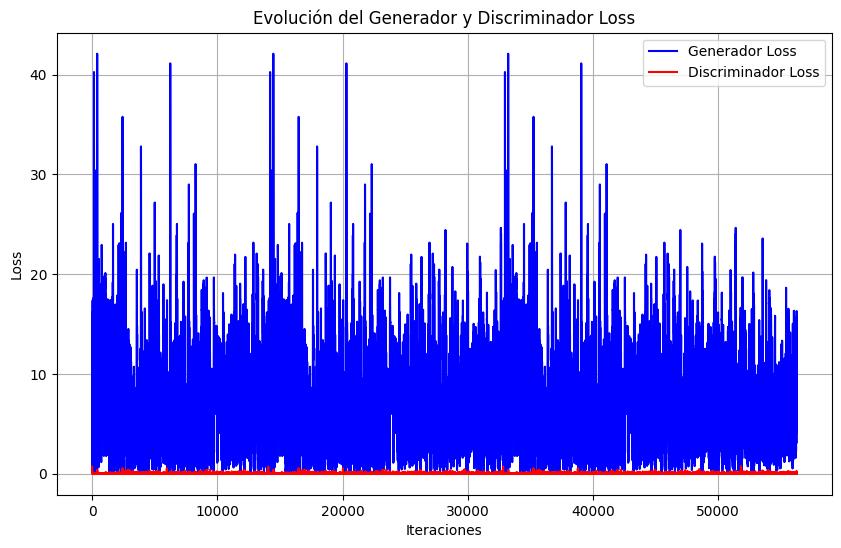

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Crear un DataFrame con las pérdidas totales
df = pd.DataFrame({
    'g_loss': g_loss_total,
    'd_loss': d_loss_total
})

# Graficar los `loss` del generador y discriminador
plt.figure(figsize=(10,6))
plt.plot(df['g_loss'], label='Generador Loss', color='blue')
plt.plot(df['d_loss'], label='Discriminador Loss', color='red')
plt.title('Evolución del Generador y Discriminador Loss')
plt.xlabel('Iteraciones')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


###5. Visualización de los Resultados
Al finalizar el entrenamiento, visualizamos las imágenes generadas:

In [ ]:
# Ruta del modelo que deseas cargar
model_ = '/content/drive/MyDrive/SIS420-IA2/Laboratorios/LAB-05/GANs_modelo_15.pth'

# Función para cargar el modelo
epoch, g_loss, d_loss = load_model(model_, generator, discriminator, g_optimizer, d_optimizer)

# Imprimir información del modelo cargado
print(f"Checkpoint del epoch {epoch} cargado: g_loss = {g_loss[-1]}, d_loss = {d_loss[-1]}")


Checkpoint loaded from epoch 15
Checkpoint del epoch 15 cargado: g_loss = 6.005204200744629, d_loss = 0.0042983777821063995


<ipython-input-17-af439731a3a6>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mo1del = torch.load(checkpoint_path)


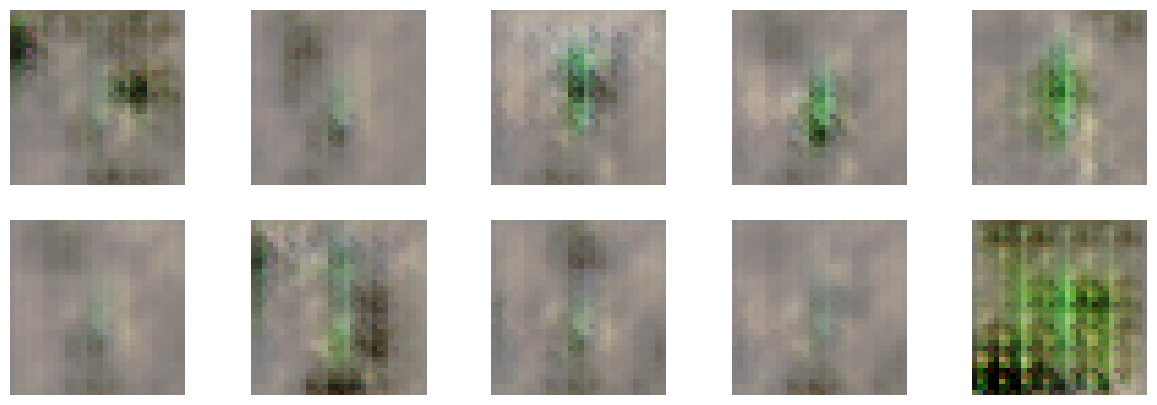

In [ ]:
import matplotlib.pyplot as plt

# Poner el generador en modo de evaluación
generator.eval()

# Generar imágenes sin calcular gradientes
with torch.no_grad():
    # Crear ruido aleatorio para generar 10 imágenes
    noise = torch.randn((10, generator.input_size)).to(device)

    # Generar imágenes a partir del ruido
    generated_images = generator(noise)

    # Configurar la figura para mostrar las imágenes
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    i = 0

    # Iterar por cada eje y mostrar las imágenes
    for ax in axs:
        for _ax in ax:
            # Reorganizar los canales de las imágenes para visualización (de [C, H, W] a [H, W, C])
            img = generated_images[i].permute(1, 2, 0).cpu()

            # Reescalar los valores de imagen de [-1, 1] a [0, 1] para visualización
            _ax.imshow((img + 1) / 2)
            _ax.axis('off')  # Ocultar los ejes
            i += 1

    # Mostrar las imágenes generadas
    plt.show()


En este caso las imágenes generadas son un poco mejores que las que obteníamos con la GAN simple, aunque todavía hay márgen de mejora.